In [1]:
import sys
import os
import random
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt

from bgm import *
from sagan import *
from causal_model import *
from load_data import *

In [2]:
root_folder = 'dataset/celebA/'
img_dim = 64
batch_size = 128

cols = ['Smiling', 'Male', 'High_Cheekbones', 'Mouth_Slightly_Open', 'Narrow_Eyes', 'Chubby']
num_label = len(cols)

test_dataloader = get_dataloader(root_folder,'dear_test', img_dim=img_dim, 
                                    batch_size=batch_size, cols = cols)    

In [3]:
in_channels = 3
fc_size = 2048
latent_dim = 100

g_conv_dim = 32
enc_dist='gaussian'
enc_arch='resnet'
enc_fc_size=2048
enc_noise_dim=128
dec_dist = 'implicit'
prior = 'linscm'

A = torch.zeros((num_label, num_label))
A[0, 2:6] = 1
A[1, 4] = 1

In [4]:
model = BGM(latent_dim, g_conv_dim, img_dim,
                enc_dist, enc_arch, enc_fc_size, enc_noise_dim, dec_dist,
                prior, num_label, A)
model = nn.DataParallel(model)

In [5]:
checkpoint = torch.load('saved_model/bgm', map_location='cpu')

In [6]:
model.load_state_dict(checkpoint['model_state_dict'])
model = model.module.to('cpu')

In [7]:
def plot_image(fake, c=10, r=None, ):
    with torch.no_grad():
        fake = np.transpose(fake.cpu().numpy(), (0, 2, 3, 1))
        r = 1 if r is None else r
        _,ax = plt.subplots(r, c, figsize=(24,3*r))
        if r == 1:
            for i in range(10):
                ax[i].imshow(fake[i])
                ax[i].set_xticks([])
                ax[i].set_yticks([])
        else:
            for i in range(r):
                ax[i][0].set_ylabel(cols[i])
                for j in range(c):
                    ax[i][j].imshow(fake[i*c+j])
                    ax[i][j].set_xticks([])
                    ax[i][j].set_yticks([])
                    
        plt.show()

Reconstruct


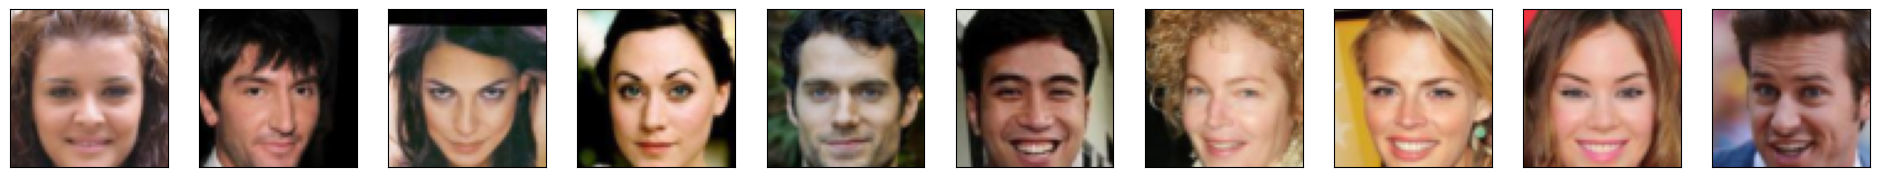

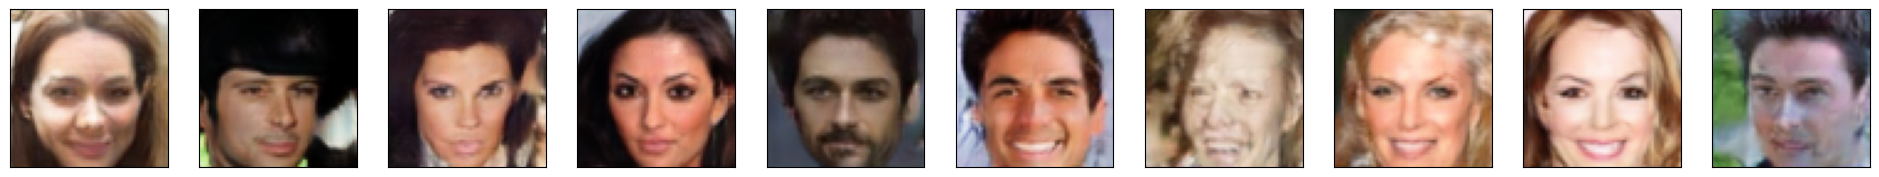

tensor([[0., 0., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 0., 1., 1., 0., 0.],
        [1., 0., 1., 1., 0., 0.],
        [1., 0., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0.]])
tensor([[1., 0., 1., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 0., 1., 1., 0., 0.],
        [1., 0., 1., 1., 0., 0.],
        [1., 0., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0., 0.]])
Random


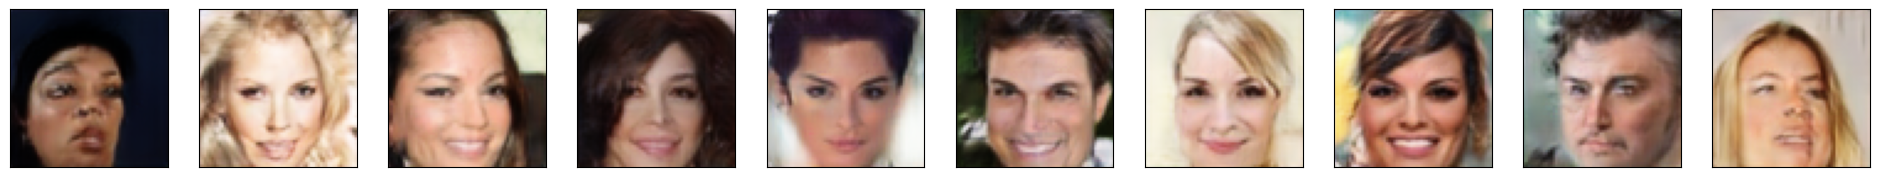

In [11]:
t = 10
for batch_idx, (x, label) in enumerate(test_dataloader):
    with torch.no_grad():
        x = x.to('cpu')
        x_ = x[:t]
        x_recon = model(x, recon=True)[:t]
        x_recon = (x_recon * 0.5) + 0.5
        print('Reconstruct')
        plot_image(x*0.5 + 0.5)
        plot_image(x_recon)
        feat = torch.sigmoid(model.prior(model(x)[:t, :num_label]))
        print(label[:t, :])
        print(torch.round(feat))
        
        print('Random')
        z = torch.randn(x.size(0), latent_dim, device=x.device)
        x_fake = model(None, z)
        x_fake = x_fake * 0.5 + 0.5
        plot_image(x_fake)
        
    break

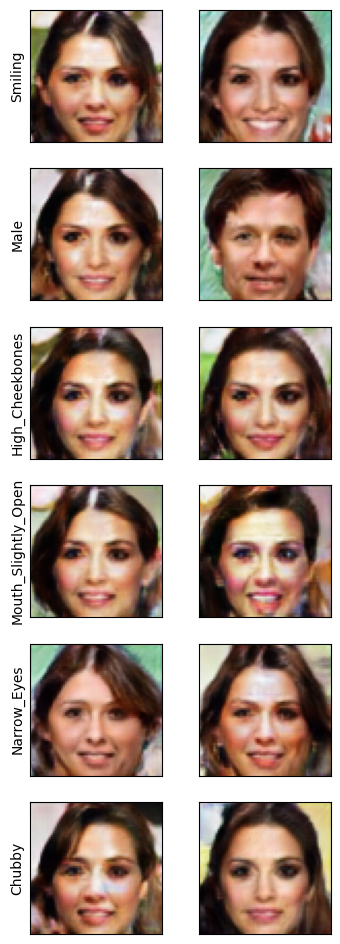

In [9]:
_, ax = plt.subplots(6,2, figsize=(4,12))
with torch.no_grad():
    for col_num in range(6):
        ax[col_num][0].set_ylabel(cols[col_num])
        fixed_zeros = torch.zeros(1, latent_dim, device='cpu')
        for i in range(2):
            fixed_zeros[:,col_num] = i
            temp = model(None, fixed_zeros)
            temp = np.transpose(temp.numpy(), (0, 2, 3, 1))[0]
            temp = temp*0.5 + 0.5
            ax[col_num][i].imshow(temp)
            ax[col_num][i].set_xticks([])
            ax[col_num][i].set_yticks([])

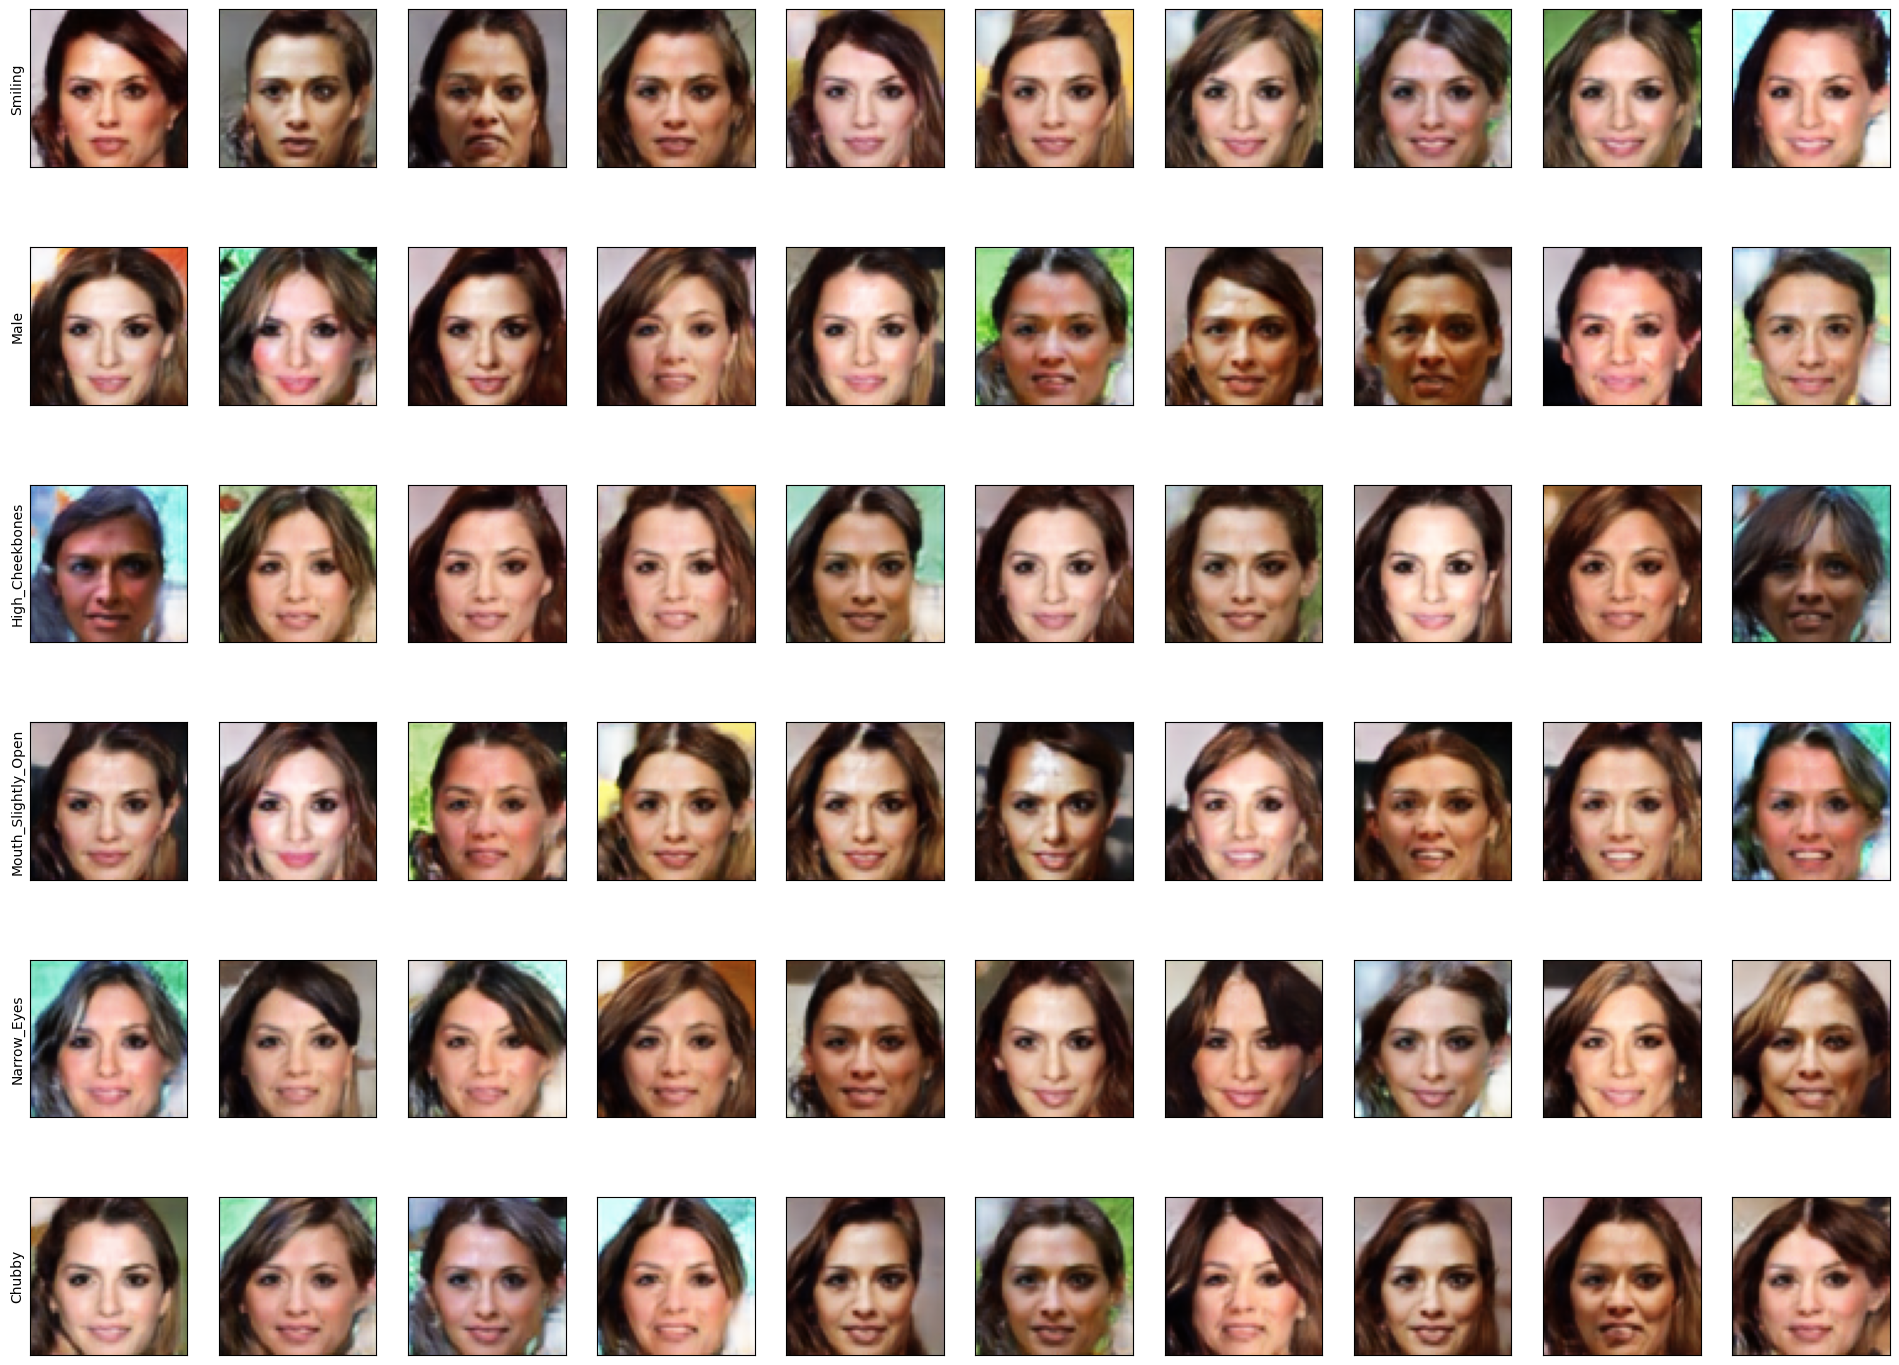

In [10]:
temp = model.traverse(fixed_zeros)
temp = temp * 0.5 + 0.5
plot_image(temp, r = 6, c = 10)